In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/home/mwirth/projects/sound-seperation")
os.getcwd()

'/home/mwirth/projects/sound-seperation'

In [3]:
from hydra import compose, initialize
from hydra.utils import instantiate
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import torch
import soundfile as sf
import librosa

In [4]:
with initialize(version_base="1.3", config_path="../../configs/"):
    cfg = compose(config_name="train.yaml", return_hydra_config=True, #overrides=["experiment=HSN/HSN_Wav2vec2.yaml"]
                  )
cfg.datamodule.hf_dataset.cache_dir = "/home/mwirth/projects/sound-seperation/data/XCM"
cfg.datamodule.loaders.train.batch_size = 5

In [5]:
ds_name = "HSN"
cache_dir = f"/home/mwirth/projects/sound-seperation/data/{ds_name}"
ds = load_dataset("DBD-research-group/BirdSet", ds_name, cache_dir=cache_dir, trust_remote_code=True, split="test")

In [6]:
m: torch.nn.Module = instantiate(cfg.module.network)["model"]

In [7]:
checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/epoch029-sisdr-loss_valid-9.8999-metric_valid9.8533.ckpt"
#checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/epoch029-snr-loss_valid-12.2272-metric_valid11.3553.ckpt"
model = torch.load(checkpoint, weights_only=False)
state_dict = {k[6:]:v for k,v in model["state_dict"].items()}
m.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
m = m.eval()

In [9]:
data = ds[7000]
wave, sr = librosa.load(data["filepath"], sr=16000, duration=10, offset=5)
with torch.no_grad():
    wave = torch.tensor(wave).unsqueeze(0)
    masks, est_wave, weights = m(wave)
weights

tensor([[9.2201e-05, 7.8739e-05, 9.8433e-01, 1.5501e-02]])

In [309]:
Audio(wave, rate=16000, normalize=False)

In [310]:
Audio(est_wave[:,3].flatten(), rate=16000, normalize=False)

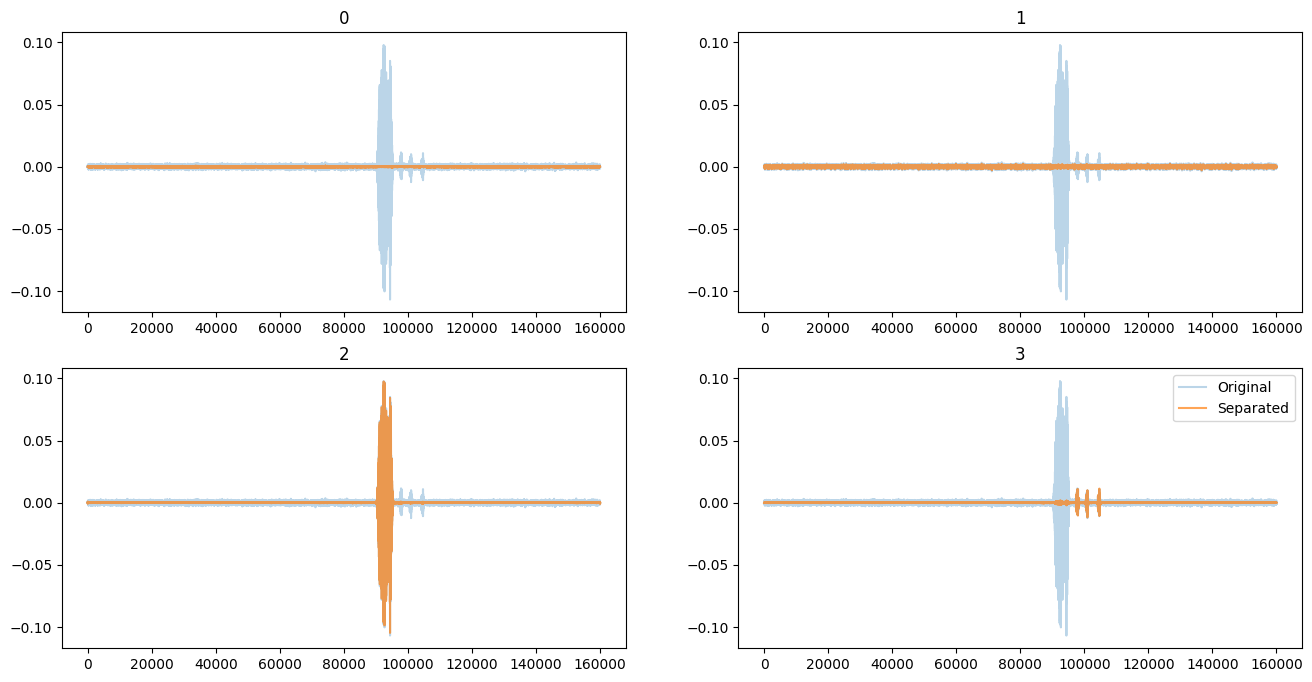

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i in range(est_wave.shape[1]):
    axes[i // 2][i%2].plot(wave.flatten(), alpha=0.3, label="Original")
    axes[i // 2][i%2].plot(est_wave[:,i].flatten(), alpha=0.7, label="Separated")
    axes[i // 2][i%2].set_title(f"{i}")
    #axes[i//2][i%2].vlines((data["start_time"] % 10)*16000, wave.flatten().min(), wave.flatten().max())
    #axes[i//2][i%2].vlines((data["end_time"] % 10)*16000, wave.flatten().min(), wave.flatten().max())
axes[-1][-1].legend()

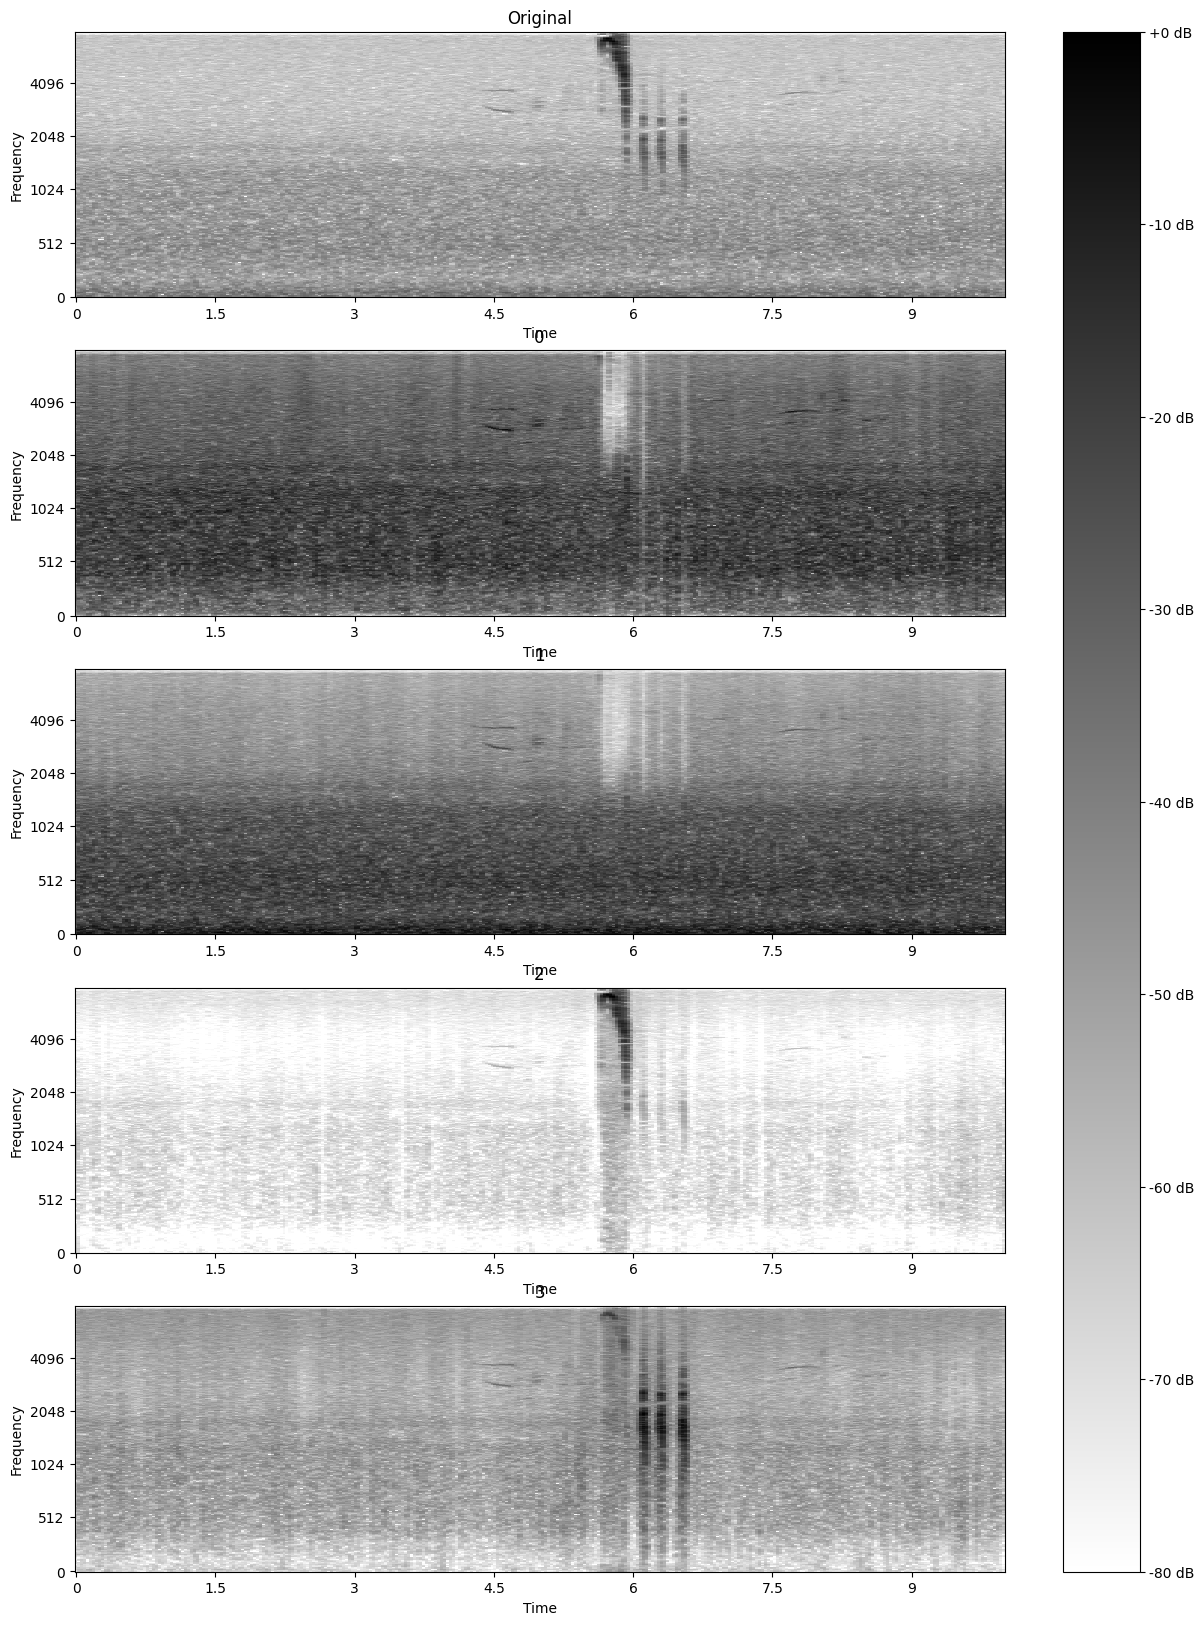

In [11]:
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
S = librosa.feature.melspectrogram(y=wave.flatten().numpy(), sr=16000, n_mels=512)
S_db = librosa.power_to_db(S, ref=np.max)

# Overlay the spectrograms with different tints
img = librosa.display.specshow(S_db, sr=16000, ax=axes[0], x_axis='time', y_axis='mel', cmap="gray_r")

for i in range(1, est_wave.shape[1]+1):
    # Compute the spectrogram
    S = librosa.feature.melspectrogram(y=est_wave[:,i-1].flatten().numpy(), sr=16000, n_mels=512)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Overlay the spectrograms with different tints
    img = librosa.display.specshow(S_db, sr=16000, ax=axes[i], x_axis='time', y_axis='mel', cmap="gray_r")
    

    axes[i].set_title(f"{i-1}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Frequency")

axes[0].set_title(f"Original")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Frequency")
fig.colorbar(img, ax=axes, format="%+2.0f dB")
#plt.tight_layout()
plt.show()

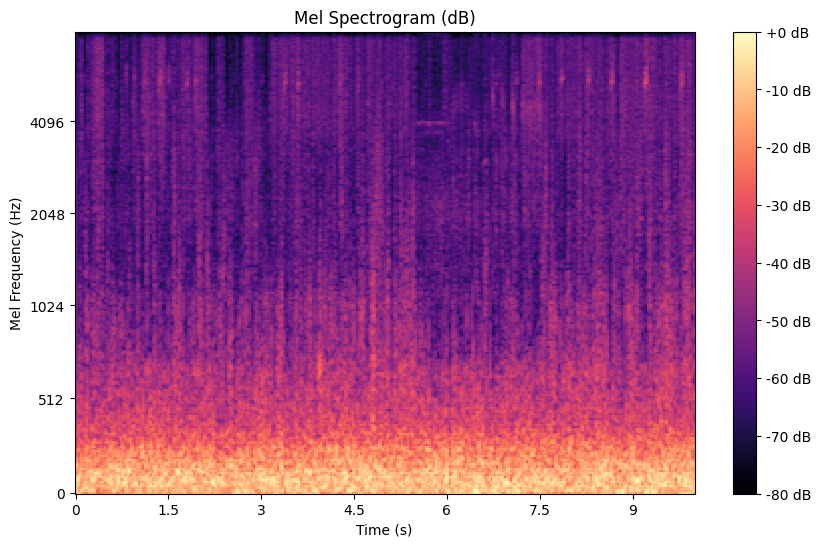

In [123]:
mel_spectrogram = librosa.feature.melspectrogram(y=est_wave[:,3].flatten().numpy(), sr=sr, n_mels=256)
# Convert to decibels for better visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency (Hz)')
plt.show()

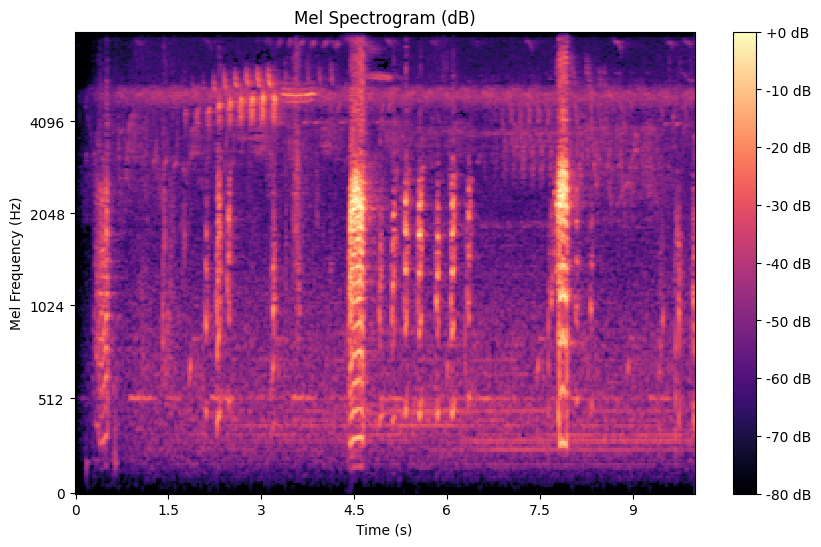

In [11]:
mel_spectrogram = librosa.feature.melspectrogram(y=wave.flatten().numpy(), sr=sr, n_mels=256)
# Convert to decibels for better visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency (Hz)')
plt.show()

In [62]:
from IPython.display import Audio

In [111]:
Audio(wave, rate=16000)

In [110]:
weights

tensor([[0.0527, 0.9473]])

In [112]:
Audio(est_wave[:,0,:], rate=16000)

In [113]:
Audio(est_wave[:,1,:], rate=16000)